# About the data
More than 3,000 rice plants from 218 cultivars in Thailand were grown under normal (Condition ID = 1), low phosphorus (Condition ID = 2), and very low phosphorus conditions (Condition ID = 3).

Then, the absorbance spectrum of the rice leaf as well as the inorganic phosphat (Pi) contents were measured. [This article](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0267304) provides more details on the methodology.

Each row corresponds to a rice plant.

Columns designate the Condition ID, Cultivar ID, Pi content, and absorbance at each wavelength from 324 nm to 784 nm.

# How to approach this dataset?
## First, check data quality and variance
* Does Condition ID, which indicates the phosphorus level in soil, correlate well with Pi content, which reflects the actual amount of phosphorus that the plant can absorb?
* How do Pi content and absorbance spectrum vary across individual plants of the same cultivar and condition?
* How much impact does cultivar have on Pi content (difference in phosphorus utilization)?

## Then, let's build some models
* How well can absorbance spectrum predict the soil phosphorus level (Condition ID)?
* How well can absorbance spectrum predict the leaf Pi content?

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import umap

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.svm import SVR

## Load data

In [3]:
data = pd.read_csv('RiceNutrientDeficiency.csv', index_col = None, header = 0)
data.head()

,ConditionID,CultivarID,Pi,324,334,344,354,364,374,384,...,694,704,714,724,734,744,754,764,774,784
0,1,1,86.223677,0.136531,0.077077,0.075083,0.061408,0.058935,0.054756,0.055509,...,0.129893,0.218741,0.304643,0.374003,0.414906,0.438958,0.445656,0.444957,0.447571,0.442941
1,1,1,104.792925,0.128571,0.092857,0.084086,0.055360,0.069373,0.050320,0.048282,...,0.117621,0.202819,0.291199,0.366811,0.410271,0.439536,0.443814,0.444727,0.444642,0.446600
2,1,1,167.335884,0.094961,0.128649,0.123823,0.066028,0.054652,0.049103,0.044307,...,0.136578,0.229855,0.320378,0.397110,0.440710,0.464248,0.473719,0.471862,0.472635,0.471684
3,1,1,215.911286,0.130802,0.087640,0.102281,0.085255,0.074521,0.064555,0.057626,...,0.138065,0.228084,0.316342,0.389543,0.429343,0.454860,0.458740,0.458078,0.461857,0.463952
4,1,1,223.691091,0.125862,0.089796,0.075459,0.095190,0.061393,0.070902,0.061411,...,0.131028,0.219312,0.309854,0.385228,0.429559,0.457268,0.462188,0.463328,0.463395,0.466131


## Analysis 1: Evaluate concordance between condition ID and Pi content
Start with a simple boxplot / violin plot

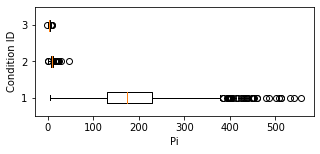

In [4]:
conditions = sorted(pd.unique(data['ConditionID']))

plt.figure(figsize = (5, 2))
plt.boxplot([data['Pi'].loc[data['ConditionID'] == c] for c in conditions], labels = conditions, vert = False)
plt.xlabel('Pi'); plt.ylabel('Condition ID')
plt.show()

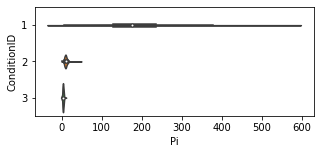

In [5]:
plt.figure(figsize = (5, 2))
_ = sns.violinplot(data = data, y = 'ConditionID', x = 'Pi', orient = 'h')

### Because the range of Pi content is quite wide, log-scale can provide a better view

In [6]:
data['Log Pi'] = np.log1p(data['Pi']) ## log1p(x) = log(1 + x), avoid the problem of log(0)

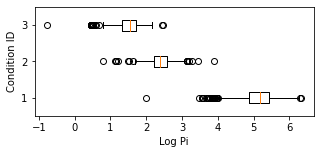

In [7]:
conditions = sorted(pd.unique(data['ConditionID']))

plt.figure(figsize = (5, 2))
plt.boxplot([data['Log Pi'].loc[data['ConditionID'] == c] for c in conditions], 
            labels = conditions, vert = False)
plt.xlabel('Log Pi'); plt.ylabel('Condition ID')
plt.show()

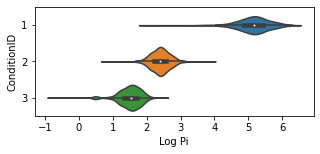

In [11]:
plt.figure(figsize = (5, 2))
_ = sns.violinplot(data = data, y = 'ConditionID', x = 'Log Pi', orient = 'h')

### Test the difference in Pi content across conditions with Mann-Whitney U test

In [12]:
print('Condition 1 vs 2:', scipy.stats.mannwhitneyu(data['Pi'].loc[data['ConditionID'] == 1],
                                                    data['Pi'].loc[data['ConditionID'] == 2]))
print('Condition 2 vs 3:', scipy.stats.mannwhitneyu(data['Pi'].loc[data['ConditionID'] == 2],
                                                    data['Pi'].loc[data['ConditionID'] == 3]))

Condition 1 vs 2: MannwhitneyuResult(statistic=1239839.0, pvalue=0.0)
Condition 2 vs 3: MannwhitneyuResult(statistic=891247.0, pvalue=5.040865367778428e-294)


## Analysis 2: Evaluate variance of Pi content across replicates
We have 5-6 replicates for each cultivar and growth condition

### This code will show the violin plot of Pi content for a random cultivar

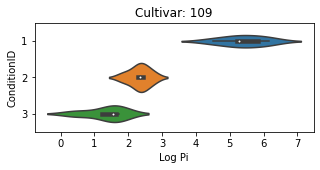

In [13]:
cultivars = pd.unique(data['CultivarID'])
random_cultivar = np.random.choice(cultivars, 1)[0]

plt.figure(figsize = (5, 2))

temp = data[['ConditionID', 'Log Pi']].loc[data['CultivarID'] == random_cultivar]

_ = sns.violinplot(data = temp, y = 'ConditionID', x = 'Log Pi', orient = 'h')
plt.title('Cultivar: ' + str(random_cultivar))

plt.show()

### This code will randomly select 20 cultivars to compare the Pi contents

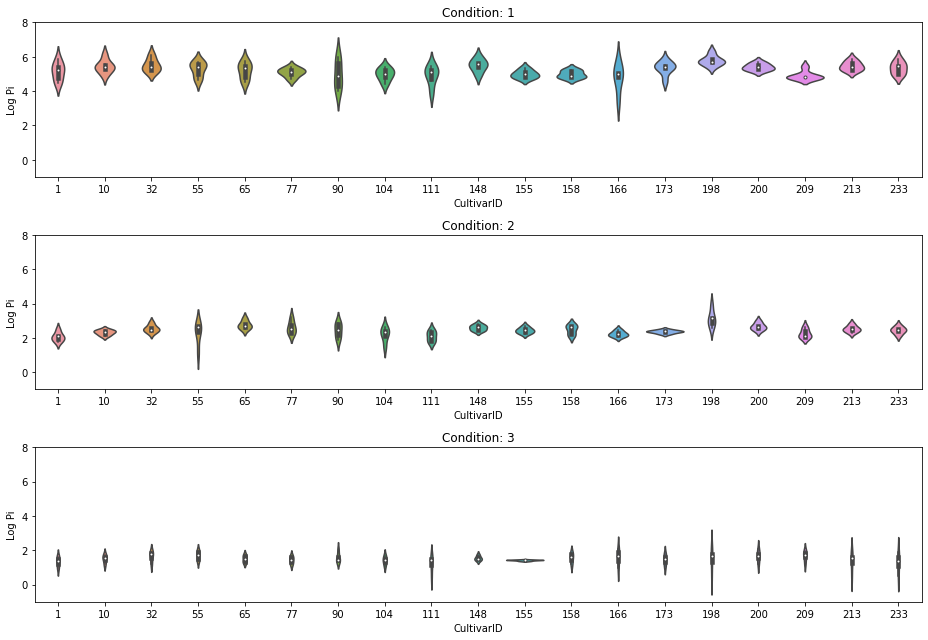

In [15]:
conditions = sorted(pd.unique(data['ConditionID']))
cultivars = pd.unique(data['CultivarID'])
random_cultivars = np.random.choice(cultivars, 20)

plt.figure(figsize = (13, 9))

for i, c in enumerate(conditions, start = 1):
    plt.subplot(3, 1, i)
    filt = data['CultivarID'].isin(random_cultivars) & (data['ConditionID'] == c)
    temp = data[['CultivarID', 'Pi']].loc[filt].copy()
    temp['Log Pi'] = np.log1p(temp['Pi'])
    
    _ = sns.violinplot(data = temp, x = 'CultivarID', y = 'Log Pi')
    plt.title('Condition: ' + str(c))
    plt.ylim([-1, 8])
    
plt.tight_layout()
plt.show()

### Calculate the average Pi content for each cultivar and condition

In [18]:
data['Cultivar-ConditionID'] = data['ConditionID'] * 1000 + data['CultivarID'] ## cultivar ID are 1-3 digits

average_pi = data[['ConditionID', 'CultivarID', 'Cultivar-ConditionID', 'Log Pi']].groupby('Cultivar-ConditionID').mean()
average_pi['ConditionID'] = average_pi['ConditionID'].astype(int)
average_pi['CultivarID'] = average_pi['CultivarID'].astype(int)
average_pi.head()

,ConditionID,CultivarID,Log Pi
Cultivar-ConditionID,,,
1001,1,1,5.155332
1002,1,2,5.491005
1003,1,3,5.206955
1004,1,4,5.242849
1005,1,5,4.738686


### Visualize the distribution of average Pi content

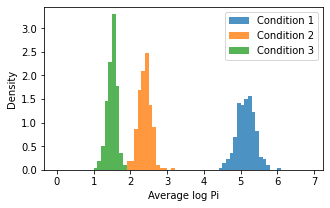

In [21]:
conditions = sorted(pd.unique(data['ConditionID']))
bins = np.arange(0, 7, 0.1)

plt.figure(figsize = (5, 3))

for cond in conditions:
    plt.hist(average_pi['Log Pi'].loc[average_pi['ConditionID'] == cond], bins = bins, density = True, 
             alpha = 0.8, label = 'Condition ' + str(cond))

plt.xlabel('Average log Pi'); plt.ylabel('Density'); plt.legend()
plt.show()

## Analysis 3: Evaluate variability in absorbance spectrum across replicates

### This code will randomly select 20 absorbance spectra to visualize

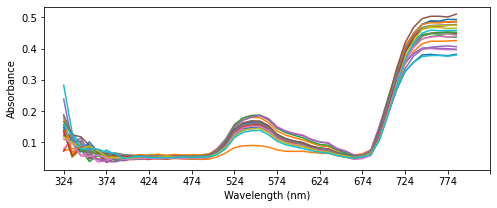

In [24]:
random_samples = np.random.choice(data.index, 20, replace = False)

plt.figure(figsize = (8, 3))

for i in random_samples:
    plt.plot(data.columns[3:-2], data.iloc[i, 3:-2])

plt.xticks(range(0, data.shape[1], 5))
plt.xlabel('Wavelength (nm)'); plt.ylabel('Absorbance')
plt.show()

### Add color based on condition ID

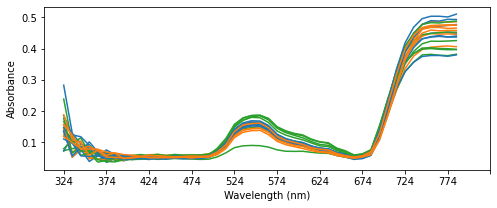

In [27]:
cmap = {1:'tab:blue', 2:'tab:orange', 3:'tab:green'}

plt.figure(figsize = (8, 3))

for i in random_samples:
    plt.plot(data.columns[3:-2], data.iloc[i, 3:-2], c = cmap[data['ConditionID'].iloc[i]])

plt.xticks(range(0, data.shape[1], 5))
plt.xlabel('Wavelength (nm)'); plt.ylabel('Absorbance')
plt.show()

### Focusing on specific wavelengths
Select 5 representative wavelengths uniformly

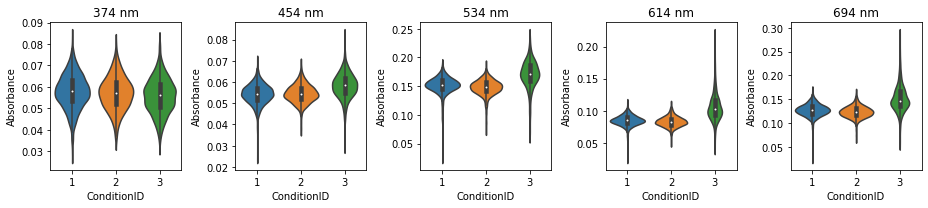

In [32]:
selected_wavelengths = data.columns[range(8, data.shape[1], 8)][:5]

plt.figure(figsize = (13, 3))

for i in range(len(selected_wavelengths)):
    plt.subplot(1, len(selected_wavelengths), i + 1)
    sns.violinplot(data = data, x = 'ConditionID', y = selected_wavelengths[i])
    plt.title(str(selected_wavelengths[i]) + ' nm')
    plt.ylabel('Absorbance')

plt.tight_layout()
plt.show()

### Visualize distribution of absorbance spectra with PCA and UMAP

In [33]:
std_data = (data.iloc[:, 3:-2] - data.iloc[:, 3:-2].mean()) / data.iloc[:, 3:-2].std()

### PCA

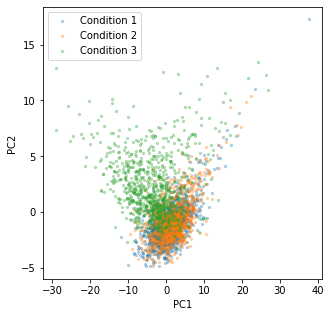

In [38]:
pca = PCA(random_state = 25).fit(std_data)
pca_embed = pca.transform(std_data)

plt.figure(figsize = (5, 5))

for cond in conditions:
    plt.scatter(pca_embed[data['ConditionID'] == cond, 0], pca_embed[data['ConditionID'] == cond, 1], 
                label = 'Condition ' + str(cond), alpha = 0.3, s = 5)
    
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.legend()
plt.show()

### UMAP with Euclidean distance
To make the process quicker, we can downsample to 1000 spectra

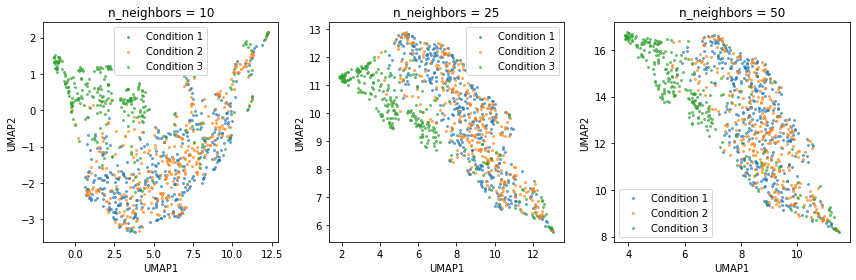

In [40]:
random_samples = np.random.choice(data.index, 1000, replace = False)
neighbors = [10, 25, 50]

plt.figure(figsize = (12, 4))

for i, n in enumerate(neighbors, start = 1):
    plt.subplot(1, len(neighbors), i)
    umap_embed = umap.UMAP(n_neighbors = n, random_state = 25).fit_transform(std_data.iloc[random_samples, :])
    
    for cond in conditions:
        filt = data['ConditionID'].iloc[random_samples] == cond
        plt.scatter(umap_embed[filt, 0], umap_embed[filt, 1], label = 'Condition ' + str(cond), 
                    s = 4, alpha = 0.6)
        
    plt.xlabel('UMAP1'); plt.ylabel('UMAP2'); plt.legend(); plt.title('n_neighbors = ' + str(n))
    
plt.tight_layout()
plt.show()

## Analysis 4: Predict P-deficiency status in soil from absorbance spectrum
Predict growth conditions: 1, 2, or 3

In [41]:
data['ConditionID'].value_counts()

1    1184
2    1048
3     862
Name: ConditionID, dtype: int64

### Split 80-20 for training and testing
Stratify the split to preserve the sample ratio

In [67]:
X_train, X_test, y_train, y_test = train_test_split(std_data, data['ConditionID'], test_size = 0.2,
                                                    stratify = data['ConditionID'], shuffle = True, random_state = 25)

In [44]:
y_train.value_counts()

1    947
2    838
3    690
Name: ConditionID, dtype: int64

In [45]:
y_test.value_counts()

1    237
2    210
3    172
Name: ConditionID, dtype: int64

### For the training data, we will generate 5 partition for cross-validation

In [46]:
cv_splitter = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 25)

In [49]:
for train_index, val_index in cv_splitter.split(X_train, y_train):
    print(train_index)

[   0    1    3 ... 2471 2472 2473]
[   0    2    3 ... 2470 2471 2474]
[   0    1    2 ... 2472 2473 2474]
[   1    2    3 ... 2472 2473 2474]
[   0    1    2 ... 2472 2473 2474]


### Use Logistic Regression
Two key hyperparameters: **Penalty (regularization)** = [l1, l2], **C (inverse regularization strength)** = [1e-5, 1e-3, 1, 1e3, 1e5]

**GridSearchCV** will try all hyperparameter combinations and report the resulting accuracy

In [50]:
base_logistic = LogisticRegression(solver = 'liblinear', max_iter = 1000, random_state = 25)
params = {'penalty': ['l1', 'l2'], 'C': [1e-5, 1e-3, 1, 1e3, 1e5]}

gridcv = GridSearchCV(base_logistic, param_grid = params, scoring = 'accuracy', refit = True, cv = cv_splitter)
gridcv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25, shuffle=True),
             estimator=LogisticRegression(max_iter=1000, random_state=25,
                                          solver='liblinear'),
             param_grid={'C': [1e-05, 0.001, 1, 1000.0, 100000.0],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

### View top models sorted by accuracy

In [51]:
grid_result = pd.DataFrame.from_dict(gridcv.cv_results_)
grid_result = grid_result.sort_values('rank_test_score')
grid_result[['params', 'mean_test_score', 'std_test_score']].head(5)

,params,mean_test_score,std_test_score
7,"{'C': 1000.0, 'penalty': 'l2'}",0.751919,0.009249
9,"{'C': 100000.0, 'penalty': 'l2'}",0.751919,0.010489
6,"{'C': 1000.0, 'penalty': 'l1'}",0.751515,0.010141
8,"{'C': 100000.0, 'penalty': 'l1'}",0.751515,0.009979
4,"{'C': 1, 'penalty': 'l1'}",0.744646,0.011183


### Conclusion:
* The best accuracy is 75%
* Choice of hyperparameters have small impact on model performance

### View classification performance report on the test set

In [52]:
y_pred = gridcv.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.70      0.76      0.73       237
           2       0.70      0.62      0.66       210
           3       0.90      0.92      0.91       172

    accuracy                           0.76       619
   macro avg       0.77      0.77      0.77       619
weighted avg       0.75      0.76      0.75       619



### View confusion matrix

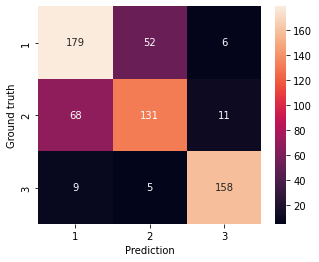

In [58]:
plt.figure(figsize = (5, 4))

sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt = 'd')
plt.xlabel('Prediction'); plt.ylabel('Ground truth')
plt.xticks(ticks = np.arange(0.5, 3.5), labels = [1, 2, 3])
plt.yticks(ticks = np.arange(0.5, 3.5), labels = [1, 2, 3])

plt.show()

### We can reframe the task as identifying condition 3 (very low phosphorus in soil)

In [61]:
lowP_label = data['ConditionID'] == 3

X_train_lowP, X_test_lowP, y_train_lowP, y_test_lowP = train_test_split(std_data, lowP_label, test_size = 0.2,
                                                                        stratify = lowP_label, shuffle = True, 
                                                                        random_state = 25)

In [63]:
gridcv_lowP = GridSearchCV(base_logistic, param_grid = params, scoring = 'accuracy', refit = True, cv = cv_splitter)
gridcv_lowP.fit(X_train_lowP, y_train_lowP)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=25, shuffle=True),
             estimator=LogisticRegression(max_iter=1000, random_state=25,
                                          solver='liblinear'),
             param_grid={'C': [1e-05, 0.001, 1, 1000.0, 100000.0],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [64]:
grid_result_lowP = pd.DataFrame.from_dict(gridcv_lowP.cv_results_)
grid_result_lowP = grid_result_lowP.sort_values('rank_test_score')
grid_result_lowP[['params', 'mean_test_score', 'std_test_score']].head(5)

,params,mean_test_score,std_test_score
6,"{'C': 1000.0, 'penalty': 'l1'}",0.950303,0.011471
8,"{'C': 100000.0, 'penalty': 'l1'}",0.950303,0.011471
7,"{'C': 1000.0, 'penalty': 'l2'}",0.949899,0.011385
9,"{'C': 100000.0, 'penalty': 'l2'}",0.949899,0.011385
5,"{'C': 1, 'penalty': 'l2'}",0.942222,0.014262


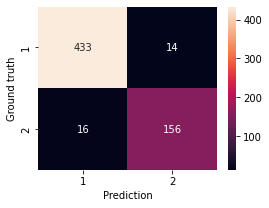

In [96]:
y_pred_lowP = gridcv_lowP.predict(X_test_lowP)

plt.figure(figsize = (4, 3))

sns.heatmap(confusion_matrix(y_test_lowP, y_pred_lowP), annot = True, fmt = 'd')
plt.xlabel('Prediction'); plt.ylabel('Ground truth')
plt.xticks(ticks = np.arange(0.5, 2.5), labels = [1, 2])
plt.yticks(ticks = np.arange(0.5, 2.5), labels = [1, 2])

plt.show()

### Visualize prediction vs ground truth on UMAP
Fit UMAP using only training data, and transform test data

In [68]:
umap = umap.UMAP(n_neighbors = 25, random_state = 25).fit(X_train)
umap_train = umap.transform(X_train)
umap_test = umap.transform(X_test)

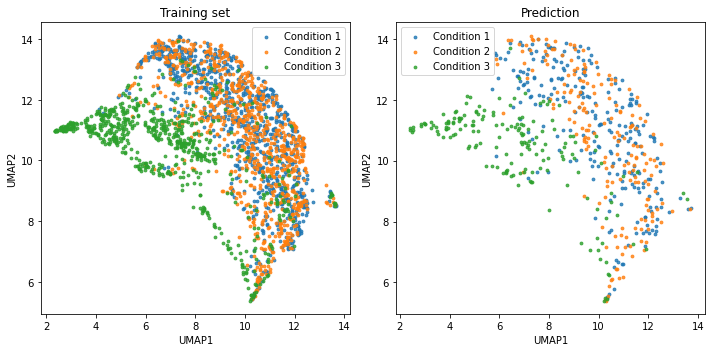

In [73]:
cmap = {1:'tab:blue', 2:'tab:orange', 3:'tab:green'}
plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)

for cond in conditions:
    filt = data['ConditionID'].loc[X_train.index] == cond
    plt.scatter(umap_train[filt, 0], umap_train[filt, 1], c = cmap[cond], label = 'Condition ' + str(cond), s = 8, alpha = 0.8)
    
plt.xlabel('UMAP1'); plt.ylabel('UMAP2'); plt.legend(); plt.title('Training set')
    
plt.subplot(1, 2, 2)

for cond in conditions:
    filt = y_pred == cond
    plt.scatter(umap_test[filt, 0], umap_test[filt, 1], c = cmap[cond], label = 'Condition ' + str(cond), s = 8, alpha = 0.8)
        
plt.xlabel('UMAP1'); plt.ylabel('UMAP2'); plt.legend(); plt.title('Prediction')

plt.tight_layout()
plt.show()

### View ROC and PR curves
This will show the performance of the model across multiple confidence cutoffs

In [75]:
y_proba = gridcv.predict_proba(X_test) ## predict_proba() produces confidence scores

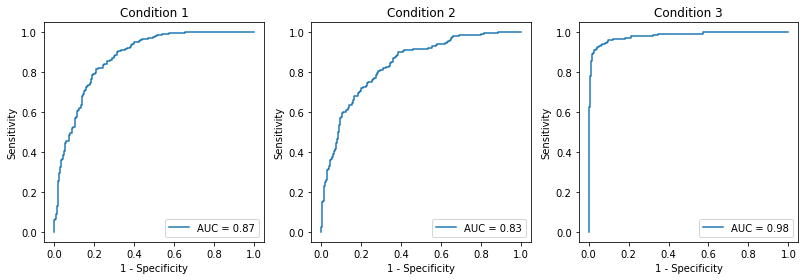

In [77]:
plt.figure(figsize = (15, 4))

for i in range(y_proba_logistic.shape[1]):
    plt.subplot(1, 4, i + 1)

    fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, i], pos_label = i + 1)
    plt.plot(fpr, tpr, label = 'AUC = ' + str(roc_auc_score(y_test == i + 1, y_proba[:, i]))[:4])

    plt.legend(loc = 'lower right'); plt.title('Condition ' + str(i + 1))
    plt.xlabel('1 - Specificity'); plt.ylabel('Sensitivity')

plt.tight_layout()
plt.show()

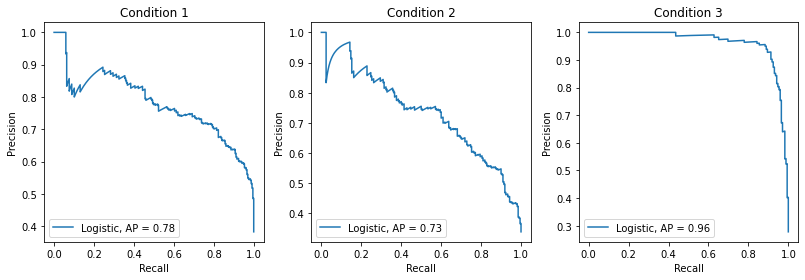

In [78]:
plt.figure(figsize = (15, 4))

for i in range(y_proba_logistic.shape[1]):
    plt.subplot(1, 4, i + 1)

    precision, recall, thresholds = precision_recall_curve(y_test, y_proba[:, i], pos_label = i + 1)
    plt.plot(recall, precision, label = 'Logistic, AP = ' + str(average_precision_score(y_test == i + 1, y_proba[:, i]))[:4])

    plt.legend(loc = 'lower left'); plt.title('Condition ' + str(i + 1))
    plt.xlabel('Recall'); plt.ylabel('Precision')

plt.tight_layout()
plt.show()

## Analysis 5: Predict Log Pi content from absorbance spectrum
Use the same data split as above

In [79]:
pi_train = data['Log Pi'].loc[y_train.index]
pi_test = data['Log Pi'].loc[y_test.index]

### Tune Ridge and Lasso models
**alpha (regularization strength)** = [1e-5, 1e-3, 1, 1e3, 1e5]

Replace **cv = cv_splitter** with **cv = cv_splitter.split(X_train_std, y_train)** because **cv_splitter** was defined with stratification

In [81]:
base_ridge = Ridge(random_state = 25)
base_lasso = Lasso(random_state = 25)
params_ridge = {'alpha': [1e-5, 1e-3, 1, 1e3, 1e5]}

gridcv_ridge = GridSearchCV(base_ridge, param_grid = params_ridge, scoring = ['neg_mean_absolute_error', 'r2'],
                            refit = 'neg_mean_absolute_error', cv = cv_splitter.split(X_train, y_train))
gridcv_lasso = GridSearchCV(base_lasso, param_grid = params_ridge, scoring = ['neg_mean_absolute_error', 'r2'],
                            refit = 'neg_mean_absolute_error', cv = cv_splitter.split(X_train, y_train))

gridcv_ridge.fit(X_train, pi_train)
gridcv_lasso.fit(X_train, pi_train)

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.400e+03, tolerance: 5.163e-01
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e+03, tolerance: 5.163e-01
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.450e+03, tolerance: 5.176e-01
  model = cd_fast.enet_coo

GridSearchCV(cv=<generator object _BaseKFold.split at 0x0000019D6EA5D5F0>,
             estimator=Lasso(random_state=25),
             param_grid={'alpha': [1e-05, 0.001, 1, 1000.0, 100000.0]},
             refit='neg_mean_absolute_error',
             scoring=['neg_mean_absolute_error', 'r2'])

In [82]:
grid_result_ridge = pd.DataFrame.from_dict(gridcv_ridge.cv_results_)
grid_result_ridge = grid_result_ridge.sort_values('rank_test_neg_mean_absolute_error')
grid_result_ridge[['params', 'mean_test_neg_mean_absolute_error', 'mean_test_r2']].head(5)

,params,mean_test_neg_mean_absolute_error,mean_test_r2
0,{'alpha': 1e-05},-1.027591,0.427916
1,{'alpha': 0.001},-1.027603,0.427920
2,{'alpha': 1},-1.039652,0.425636
3,{'alpha': 1000.0},-1.187758,0.327580
4,{'alpha': 100000.0},-1.440994,0.082523


In [83]:
grid_result_lasso = pd.DataFrame.from_dict(gridcv_lasso.cv_results_)
grid_result_lasso = grid_result_lasso.sort_values('rank_test_neg_mean_absolute_error')
grid_result_lasso[['params', 'mean_test_neg_mean_absolute_error', 'mean_test_r2']].head(5)

,params,mean_test_neg_mean_absolute_error,mean_test_r2
0,{'alpha': 1e-05},-1.035656,0.419191
1,{'alpha': 0.001},-1.040947,0.422251
2,{'alpha': 1},-1.492175,-0.000447
3,{'alpha': 1000.0},-1.492175,-0.000447
4,{'alpha': 100000.0},-1.492175,-0.000447


### Ridge regression with alpha = 1e-5 achieves the lowest MAE of 1.0276

### Visualize predicted Log Pi versus ground truth

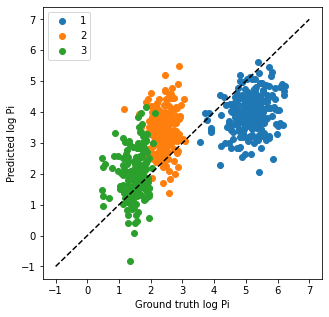

In [84]:
pi_ridge = gridcv_ridge.predict(X_test)

plt.figure(figsize = (5, 5))

for c in conditions:
    filt = data['ConditionID'].loc[y_test.index] == c
    plt.scatter(pi_test.loc[filt], pi_ridge[filt], label = c)

plt.plot([-1, 7], [-1, 7], '--k')
plt.xlabel('Ground truth log Pi'); plt.ylabel('Predicted log Pi'); plt.legend()
plt.show()

### Let's try some non-linear models
Support Vector Regressor with radial basis kernel

Tune **epsilon** from 0 to 2

In [88]:
base_svr = SVR(kernel = 'rbf')
params_svr = {'epsilon': np.arange(0, 2, 0.2)}

gridcv_svr = GridSearchCV(base_svr, param_grid = params_svr, scoring = ['neg_mean_absolute_error', 'r2'],
                          refit = 'neg_mean_absolute_error', cv = cv_splitter.split(X_train, y_train))

gridcv_svr.fit(X_train, pi_train)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x0000019D6E65BF90>,
             estimator=SVR(),
             param_grid={'epsilon': array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8])},
             refit='neg_mean_absolute_error',
             scoring=['neg_mean_absolute_error', 'r2'])

In [89]:
grid_result_svr = pd.DataFrame.from_dict(gridcv_svr.cv_results_)
grid_result_svr = grid_result_svr.sort_values('rank_test_neg_mean_absolute_error')
grid_result_svr[['params', 'mean_test_neg_mean_absolute_error', 'mean_test_r2']].head(5)

,params,mean_test_neg_mean_absolute_error,mean_test_r2
1,{'epsilon': 0.2},-0.971163,0.399953
0,{'epsilon': 0.0},-0.972368,0.389153
2,{'epsilon': 0.4},-0.980082,0.414062
3,{'epsilon': 0.6000000000000001},-0.998960,0.424135
4,{'epsilon': 0.8},-1.031324,0.427877


### Compare predicted Log Pi from the best SVR model with ground truth

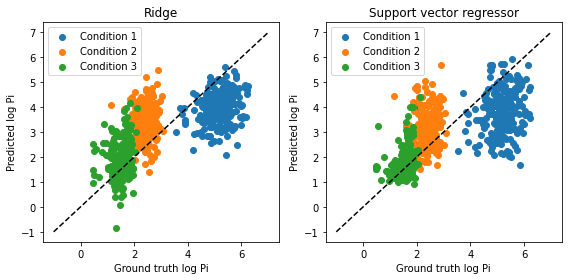

In [95]:
pi_svr = gridcv_svr.predict(X_test)

plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)

for cond in conditions:
    filt = data['ConditionID'].loc[y_test.index] == cond
    plt.scatter(pi_test.loc[filt], pi_ridge[filt], label = 'Condition ' + str(cond))

plt.plot([-1, 7], [-1, 7], '--k')
plt.xlabel('Ground truth log Pi'); plt.ylabel('Predicted log Pi'); plt.legend()
plt.title('Ridge')

plt.subplot(1, 2, 2)

for cond in conditions:
    filt = data['ConditionID'].loc[y_test.index] == cond
    plt.scatter(pi_test.loc[filt], pi_svr[filt], label = 'Condition ' + str(cond))
    
plt.plot([-1, 7], [-1, 7], '--k')
plt.xlabel('Ground truth log Pi'); plt.ylabel('Predicted log Pi'); plt.legend()
plt.title('Support vector regressor')

plt.tight_layout()
plt.show()